### Описание задания:
Решить задачу классификации наличия болезни сердца у пациентов, применяя базовые ансамблевые методы. Целевая переменная – наличие болезни сердца (HeartDisease), принимает значения 0 или 1 в зависимости от отсутствия или наличия болезни соответственно.

### Этапы работы:

1) Получите данные и загрузите их в рабочую среду

2) Подготовьте датасет к обучению моделей.
**a)** Категориальные переменные переведите в цифровые значения. Можно использовать pd.get_dummies, preprocessing.LabelEncoder. Старайтесь не использовать для этой задачи циклы.
**b)** *Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака).

3) Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

4) Обучите дерево решений на обучающем множестве. Используйте следующие модели:
**a)** tree.DecisionTreeClassifier
**b)** ensemble.RandomForestClassifier

5) Для тестового множества сделайте предсказание целевой переменной. Выведите метрики для каждой построенной модели с помощью metrics.classification_report.

6) Выведите важность признаков, полученную после обучения модели из п. 4b в виде столбчатой диаграммы. Отсортируйте важность по убыванию.

7) Обучите бэггинг над моделью из п. 4a. Используйте ensemble.BaggingClassifier.
**a)** Повторите п. 5

8) Обучите стекинг трех моделей: из п. 4a, п. 4b и svm.LinearSVC. Используйте ensemble.StackingClassifier.
**a)** Повторите п. 5

9) Сформулируйте выводы по проделанной работе.
**a)** Сравните метрики построенных моделей.
**b)** Напишите свое мнение, какая модель наилучшая и почему.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.duplicated().sum()

0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Построение графика

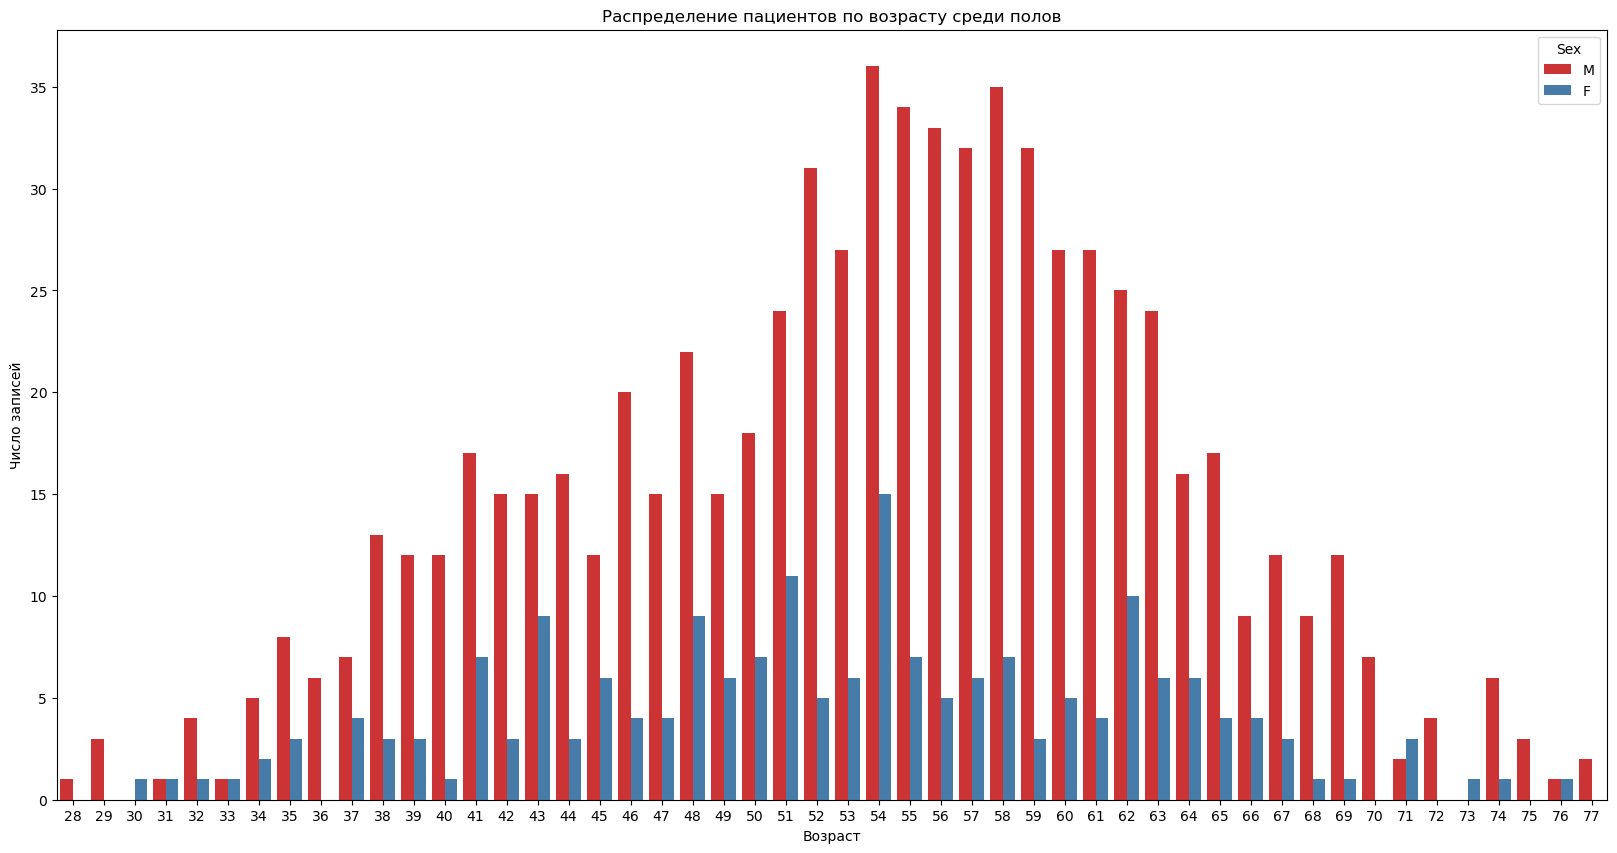

In [5]:
plt.figure(figsize=[20,10])
diag = sns.countplot(x='Age', hue='Sex', data=data, palette='Set1')
diag.set_xlabel('Возраст')
diag.set_ylabel('Число записей')
diag.set_title('Распределение пациентов по возрасту среди полов')
plt.show()

По графику мы видим распределение пациентов по возрасту и полу. Записи по мужчинам сильно преобладают над записями по женщинами

### Преобразование категориальных признаков

In [6]:
categorials = list(data.dtypes[data.dtypes == object].index)
dummy = pd.get_dummies(data[categorials], columns=categorials)

In [7]:
data = pd.concat([dummy, data.drop(columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])], axis=1)
data.head()

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0,1,0,1,0,0,0,1,0,1,...,0,0,1,40,140,289,0,172,0.0,0
1,1,0,0,0,1,0,0,1,0,1,...,0,1,0,49,160,180,0,156,1.0,1
2,0,1,0,1,0,0,0,0,1,1,...,0,0,1,37,130,283,0,98,0.0,0
3,1,0,1,0,0,0,0,1,0,0,...,0,1,0,48,138,214,0,108,1.5,1
4,0,1,0,0,1,0,0,1,0,1,...,0,0,1,54,150,195,0,122,0.0,0


In [8]:
X = data[data.columns[:-1]]
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Обучение моделей

**(a) Обучение дерева решений на обучающем множестве используя sklearn.tree.DecisionTreeClassifier**

In [9]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

**(b) Обучение дерева решений на обучающем множестве используя sklearn.ensemble.RandomForestClassifier**

In [10]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [11]:
predict_decision_tree = decision_tree.predict(X_test)
predict_random_forest = random_forest.predict(X_test)

In [12]:
print(classification_report(y_test, predict_decision_tree))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        77
           1       0.87      0.79      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.81       184



In [13]:
print(classification_report(y_test, predict_random_forest))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        77
           1       0.90      0.90      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



Качество модели при использовании RandomForestClassifier лучше

#### Выведение важности признаков

In [14]:
feature_importances = random_forest.feature_importances_
indices = np.argsort(feature_importances)
features = X.columns.values

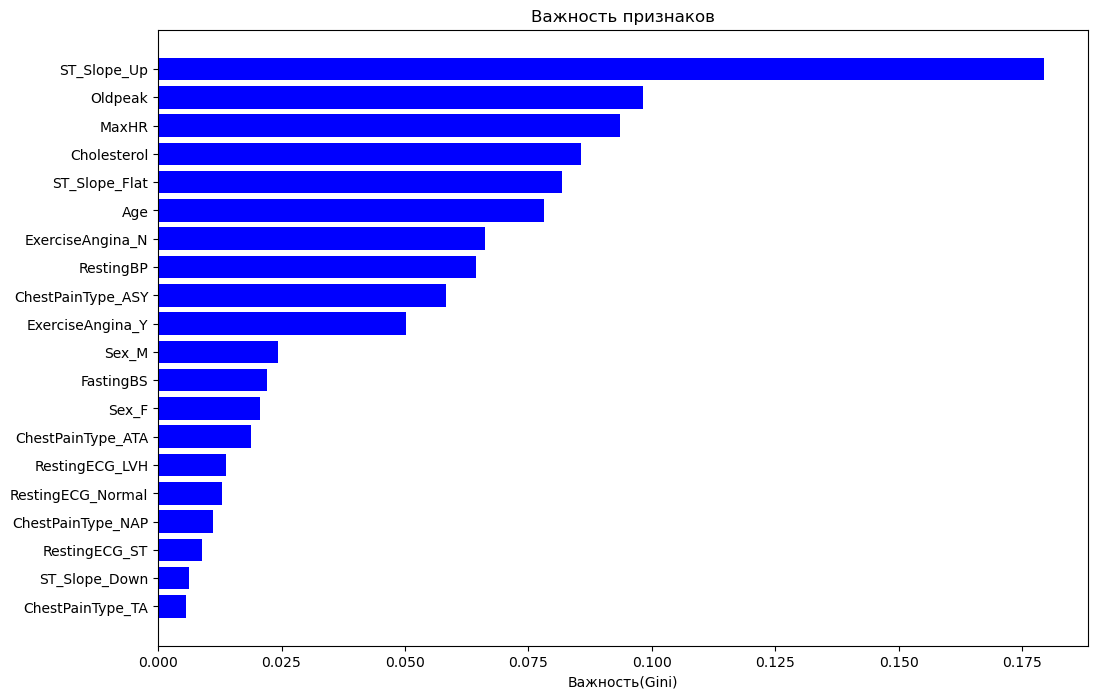

In [15]:
plt.subplots(figsize=(12, 8))
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Важность(Gini)')
plt.title('Важность признаков')
plt.show()

### Бегинг

In [16]:
bagging = BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=0.5)

In [17]:
bagging.fit(X_train, y_train)
predict_bagging_dtc = bagging.predict(X_test)

In [18]:
print(classification_report(y_test, predict_bagging_dtc))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        77
           1       0.91      0.84      0.87       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



### Стекинг:

- sklearn.tree.DecisionTreeClassifier
- sklearn.ensemble.RandomForestClassifier
- svm.LinearSVC.

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
model = StackingClassifier([
    ('DecisionTreeClassifier', DecisionTreeClassifier()), 
    ('RandomForestClassifier', RandomForestClassifier()),
    ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=21)))
    ], final_estimator=LogisticRegression(solver='lbfgs', max_iter=10000))

In [21]:
model.fit(X_train, y_train)
predict_model = model.predict(X_test)

In [22]:
print(classification_report(y_test, predict_model))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



### Вывод:

Были произведены обучения моделей с использованием бэггинга и стекинга.:

- sklearn.tree.DecisionTreeClassifier
- sklearn.ensemble.RandomForestClassifier
- svm.LinearSVC

**Результаты были получены следующие (от лучшего к худшему)**:

1) модель RandomForestClassifier
2) стекинг с использованием трёх моделей
3) бэггинг на модели DecisionTreeClassifier
4) модель DecisionTreeClassifier